<a href="https://colab.research.google.com/github/bestacio89/TensorFlow/blob/develop/MaskDetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Library set up

In [44]:
# Import TensorFlow and related libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
# Other utility libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
import glob
import os
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

#Preparing the dataset

##Unzipping and organising Directories

In [45]:


# Stage 1: Unzipping and Organizing Directories

# Step 1: Unzip your dataset
zip_path = './sample_data/archive (1).zip'  # Replace with your actual zip file path
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/mask-dataset')  # Extract into this folder

# Step 2: Define base directory and create directories for train and validation sets
base_dir = '/content/mask-dataset/'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

# Create train and validation directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Step 3: Create subdirectories for classes within train and val
train_with_mask_dir = os.path.join(train_dir, 'with_mask')
train_without_mask_dir = os.path.join(train_dir, 'without_mask')
val_with_mask_dir = os.path.join(val_dir, 'with_mask')
val_without_mask_dir = os.path.join(val_dir, 'without_mask')

# Create subdirectories for each class if they don't exist
os.makedirs(train_with_mask_dir, exist_ok=True)
os.makedirs(train_without_mask_dir, exist_ok=True)
os.makedirs(val_with_mask_dir, exist_ok=True)
os.makedirs(val_without_mask_dir, exist_ok=True)

print("Directories for train and validation sets have been created.")


Directories for train and validation sets have been created.


##Preparing for dataset Split

In [46]:


# Stage 2: Preparing for Dataset Split

# Step 1: Define the directory where images are located after extraction
image_dir = os.path.join(base_dir, 'images')  # Replace 'images' with the actual subfolder if different
annotations_dir = os.path.join(base_dir, 'annotations')  # Directory where the XML files are stored

# Step 2: Get all image paths
all_images = glob.glob(os.path.join(image_dir, '*.*'))

# Step 3: Ensure there are images to split
if len(all_images) > 0:
    # Split images into 80% train and 20% validation
    train_images, val_images = train_test_split(all_images, test_size=0.2, random_state=42)

    print(f"Dataset split into {len(train_images)} train images and {len(val_images)} validation images.")
else:
    print("No images found in the specified directory.")


Dataset split into 682 train images and 171 validation images.


##Classifying and Moving Images

In [47]:
# Stage 3: Classifying and Moving Images

# Step 1: Function to classify images based on corresponding XML file
def classify_image_from_xml(image_path):
    # Get the corresponding XML file path (assuming XML name matches image name, except extension)
    xml_filename = os.path.splitext(os.path.basename(image_path))[0] + '.xml'
    xml_path = os.path.join(annotations_dir, xml_filename)

    if not os.path.exists(xml_path):
        raise FileNotFoundError(f"XML annotation file not found for {image_path}")

    # Parse the XML file to extract classification
    tree = ET.parse(xml_path)
    root = tree.getroot()

    # Loop through all objects in the XML and check if any of them has 'with_mask'
    for object_tag in root.iter('object'):
        class_name = object_tag.find('name').text.strip().lower()
        if 'with_mask' in class_name:
            return 'with_mask'
        elif 'without_mask' in class_name:
            return 'without_mask'

    # If no classification found in XML, return 'without_mask' as the default (or raise an error)
    return 'without_mask'

# Step 2: Move images to respective class folders within train and val directories
for img_path in train_images:
    try:
        class_folder = classify_image_from_xml(img_path)
        if class_folder == 'with_mask':
            shutil.move(img_path, os.path.join(train_with_mask_dir, os.path.basename(img_path)))
        else:
            shutil.move(img_path, os.path.join(train_without_mask_dir, os.path.basename(img_path)))
    except (FileNotFoundError, ValueError) as e:
        print(e)  # Handle or log invalid images here

for img_path in val_images:
    try:
        class_folder = classify_image_from_xml(img_path)
        if class_folder == 'with_mask':
            shutil.move(img_path, os.path.join(val_with_mask_dir, os.path.basename(img_path)))
        else:
            shutil.move(img_path, os.path.join(val_without_mask_dir, os.path.basename(img_path)))
    except (FileNotFoundError, ValueError) as e:
        print(e)  # Handle or log invalid images here

print("Images classified and moved to respective train/validation directories.")


Images classified and moved to respective train/validation directories.


#Data Augmentation and Preprocessing

In [48]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Only rescaling for validation
val_datagen = ImageDataGenerator(rescale=1.0/255)

# Set up data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

print("Train generator: ", train_generator)
print("Validation generator: ", val_generator)

print("Training samples:", train_generator.samples)
print("Validation samples:", val_generator.samples)


Found 682 images belonging to 2 classes.
Found 171 images belonging to 2 classes.
Train generator:  <keras.src.legacy.preprocessing.image.DirectoryIterator object at 0x7f52b87db6a0>
Validation generator:  <keras.src.legacy.preprocessing.image.DirectoryIterator object at 0x7f52bbec9cf0>
Training samples: 682
Validation samples: 171


#Building Model architecture

In [49]:
# Load MobileNetV2 and set it to non-trainable
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation="sigmoid")(x)

# Final model
model = Model(inputs=base_model.input, outputs=predictions)


#Compiling the model


In [50]:


# Use `learning_rate` instead of `lr`
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])



#Training the model

In [51]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=10  # adjust based on preference
)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.7248 - loss: 0.5684 - val_accuracy: 0.8000 - val_loss: 0.5549
Epoch 2/10
 1/21 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8438 - loss: 0.5593

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8438 - loss: 0.5593 - val_accuracy: 0.7273 - val_loss: 0.5592
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.8096 - loss: 0.5027 - val_accuracy: 0.8125 - val_loss: 0.4634
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7812 - loss: 0.4908 - val_accuracy: 0.7273 - val_loss: 0.6062
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.8210 - loss: 0.4802 - val_accuracy: 0.8188 - val_loss: 0.4453
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8125 - loss: 0.4992 - val_accuracy: 0.8182 - val_loss: 0.5361
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.8217 - loss: 0.4347 - val_accuracy: 0.8313 - val_loss: 0.4158
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7812 - loss: 0.4474 - val_accuracy: 0.8182 - val_loss: 0.6253
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.8252 - loss: 0.4403 - val_accuracy: 0.8500 - val_loss: 0.4141

#Evaluating the Model

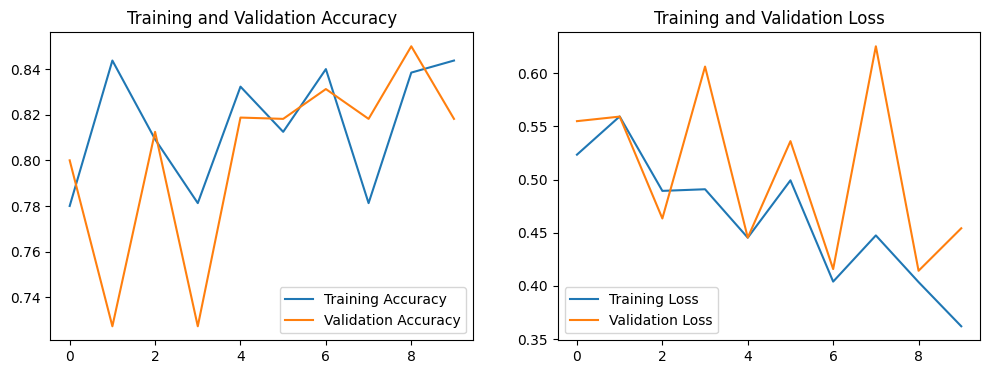

In [52]:
# Plot training & validation accuracy/loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


#Fine-tuning the model

In [54]:
# Unfreeze some layers in the base model for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:100]:  # Freeze the first 100 layers
    layer.trainable = False

# Recompile and train again with a smaller learning rate
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Fine-tune
history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=5  # fewer epochs for fine-tuning
)


Epoch 1/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step - accuracy: 0.8609 - loss: 0.3924 - val_accuracy: 0.8562 - val_loss: 0.4002
Epoch 2/5
 1/21 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.7812 - loss: 0.4871

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


21/21 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.7812 - loss: 0.4871 - val_accuracy: 0.8182 - val_loss: 0.6907
Epoch 3/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step - accuracy: 0.8793 - loss: 0.3532 - val_accuracy: 0.8687 - val_loss: 0.4200
Epoch 4/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9062 - loss: 0.3460 - val_accuracy: 0.9091 - val_loss: 0.3604
Epoch 5/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step - accuracy: 0.8740 - loss: 0.3634 - val_accuracy: 0.8813 - val_loss: 0.3884


#Testing the Model on Custom Images

In [56]:
from tensorflow.keras.preprocessing import image

def preprocess_and_predict(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    if prediction < 0.5:
        print("No mask detected")
    else:
        print("Mask detected")

# Test with an image
test_image_path = './sample_data/thebeardman.jpeg'  # replace with your image path
preprocess_and_predict(test_image_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
No mask detected


#Saving model

In [57]:
model.save("mask_detector_model.h5")


#Utilities

In [42]:
# Base directory
base_dir = '/content/'

# The folder to exclude from deletion
exclude_folder = 'sample_data'

# Walk through the base directory
for root, dirs, files in os.walk(base_dir, topdown=False):
    # Check if the folder is the one we need to exclude
    if exclude_folder in dirs:
        dirs.remove(exclude_folder)  # This will prevent the exclude folder from being deleted

    # Delete all files in the directory
    for file in files:
        file_path = os.path.join(root, file)
        os.remove(file_path)  # Delete the file

    # Delete subdirectories (except for the excluded one)
    for dir in dirs:
        dir_path = os.path.join(root, dir)
        shutil.rmtree(dir_path)  # Delete the subdirectory

print("All directories and files (except 'sample_data') have been deleted.")


All directories and files (except 'sample_data') have been deleted.
